In [1]:
import sys
sys.path[0] = ('/home/labs/waic/omrik/DNN-Challenge')
from fastai.vision import *
import pre
import resample
from metrics import Pearson

root = Path('../data').resolve()
train = root / 'train'
val = root / 'val'

In [2]:
def normalize_time(series):
    # 1440 minutes in a day
    normalized = (series.hour * 60 + series.minute) / 1440
    return normalized

def get_data(data_dir):
    cgm, meals = pre.get_dfs(data_dir)
    meals = resample.resample_meals(cgm, meals, 15)
    meals = pd.concat((meals, cgm), axis=1)
    meals['time'] = normalize_time(meals.index.get_level_values('Date'))
    cgm, y = pre.build_cgm(cgm)
    return cgm, meals, y

class ContData(Dataset):
    def __init__(self, cgm, meals, y):
        self.cgm = cgm
        self.meals = meals
        self.y = y
        
    def __len__(self):
        return len(self.cgm)
    
    def __getitem__(self, i):
        index = self.meals.index.get_loc(self.cgm.index[i])
        values = self.meals[index-48:index+1].values
        target = self.y.iloc[i].values
        x, y = torch.tensor(values, dtype=torch.float), torch.tensor(target, dtype=torch.float)
        return x, y


In [3]:
train_data = get_data(train)
val_data = get_data(val)

/home/labs/waic/omrik/DNN-Challenge/pre.py:73: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  X = X.loc[y.index].dropna(how='any', axis=0)


In [4]:
train_ds = ContData(*train_data)
val_ds = ContData(*val_data)
data = DataBunch.create(train_ds, val_ds, bs=512)
data

DataBunch;

Train: <__main__.ContData object at 0x7f482dd820b8>;

Valid: <__main__.ContData object at 0x7f482dd82128>;

Test: None

In [5]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    

class TransformerModel(Module):
    def __init__(self, d_model, nhead, nlayers, dim_feedforward=2048, dropout=0.1, decoder=None):
        super().__init__()
        self.encoder = nn.Linear(38, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        
        if decoder is None:
            decoder = nn.Sequential(
                Lambda(lambda x: x.permute(1, 2, 0)),
                nn.Linear(49, 1),
                nn.ReLU(inplace=True),
                Flatten(),
                nn.BatchNorm1d(d_model),
                nn.Linear(d_model, 8)
            )
        self.decoder = decoder
        self.d_model = d_model
        
    def forward(self, src):
        src = src.transpose(0, 1)
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output)
        return output
            

In [6]:
defaults.device = torch.device('cpu')
model = TransformerModel(128, 2, 2, dim_feedforward=256)
learner = Learner(data, model, loss_func=nn.MSELoss(), metrics=[mean_absolute_error, Pearson(val_ds.y)])

epoch,train_loss,valid_loss,mean_absolute_error,pearson,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-04
Min loss divided by 10: 8.32E-03


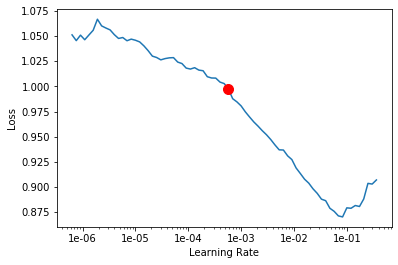

In [7]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [8]:
learner.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,mean_absolute_error,pearson,time
0,0.482596,0.576236,0.547052,0.543170,05:41
1,0.454190,0.458226,0.479054,0.590507,05:22
2,0.433797,0.433323,0.456280,0.611173,05:23
3,0.426611,0.424602,0.449927,0.618724,05:10
